In [1]:
import IPython
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.0.1
2.0.2
cpu


In [2]:
pip install deep_phonemizer

  Using cached deep-phonemizer-0.0.19.tar.gz (29 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/5.6 MB ? eta -:--:--
                                              0.0/5.6 MB 1.3 MB/s eta 0:00:05
                                              0.1/5.6 MB 648.1 kB/s eta 0:00:09
                                              0.1/5.6 MB 901.1 kB/s eta 0:00:07
     -                                        0.2/5.6 MB 1.4 MB/s eta 0:00:04
     --                                       0.4/5.6 MB 1.6 MB/s eta 0:00:04
     ---                                      0.5/5.6 MB 2.0 MB/s eta 0:00:03
     -----                                    0.8/5.6 MB 2.6 MB/s eta 0:00:02
     --------                                 1.1/5.6 MB 3.3 MB/s eta 0:00:02
     -----------                              1.6/5.6 MB 4.0 MB/s eta 0:00:02
     ---------------                          2.1/5.6 MB 4.8 MB/s et

In [6]:
# TEXT PROCESSING

In [7]:
# Character-based encoding

In [9]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

# Возвращает список индексов в symbols для символов в text
def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [10]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


In [11]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


In [12]:
# Phoneme-based encoding

In [15]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
    processed, lengths = processor(text)
    
print(processed)
print(lengths)

100%|██████████| 63.6M/63.6M [00:06<00:00, 9.82MB/s]


tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


In [16]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


In [17]:
# SPECTROGRAM GENERATION

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to C:\Users\User/.cache\torch\hub\checkpoints\tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth
100%|██████████| 107M/107M [00:09<00:00, 11.6MB/s] 


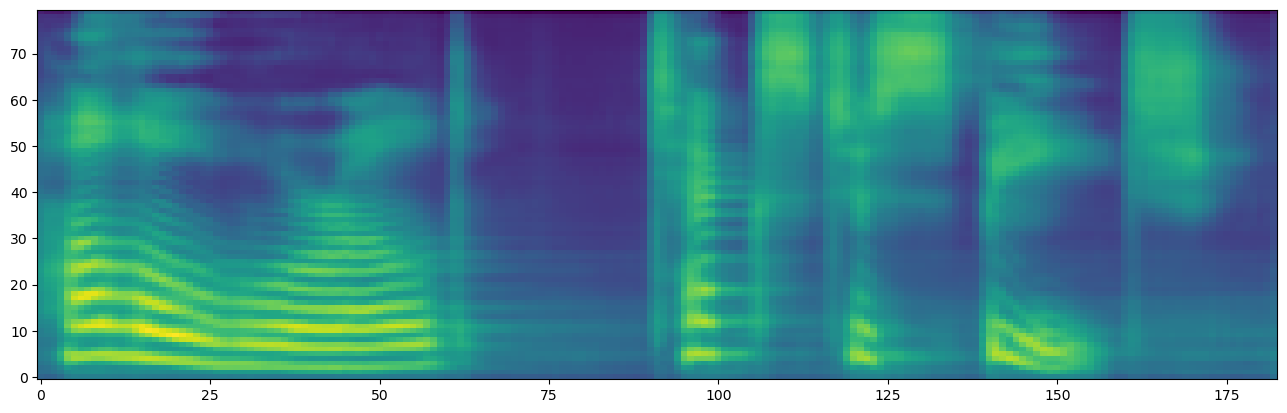

In [19]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lenghts = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)
    
_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

torch.Size([80, 179])
torch.Size([80, 177])
torch.Size([80, 214])


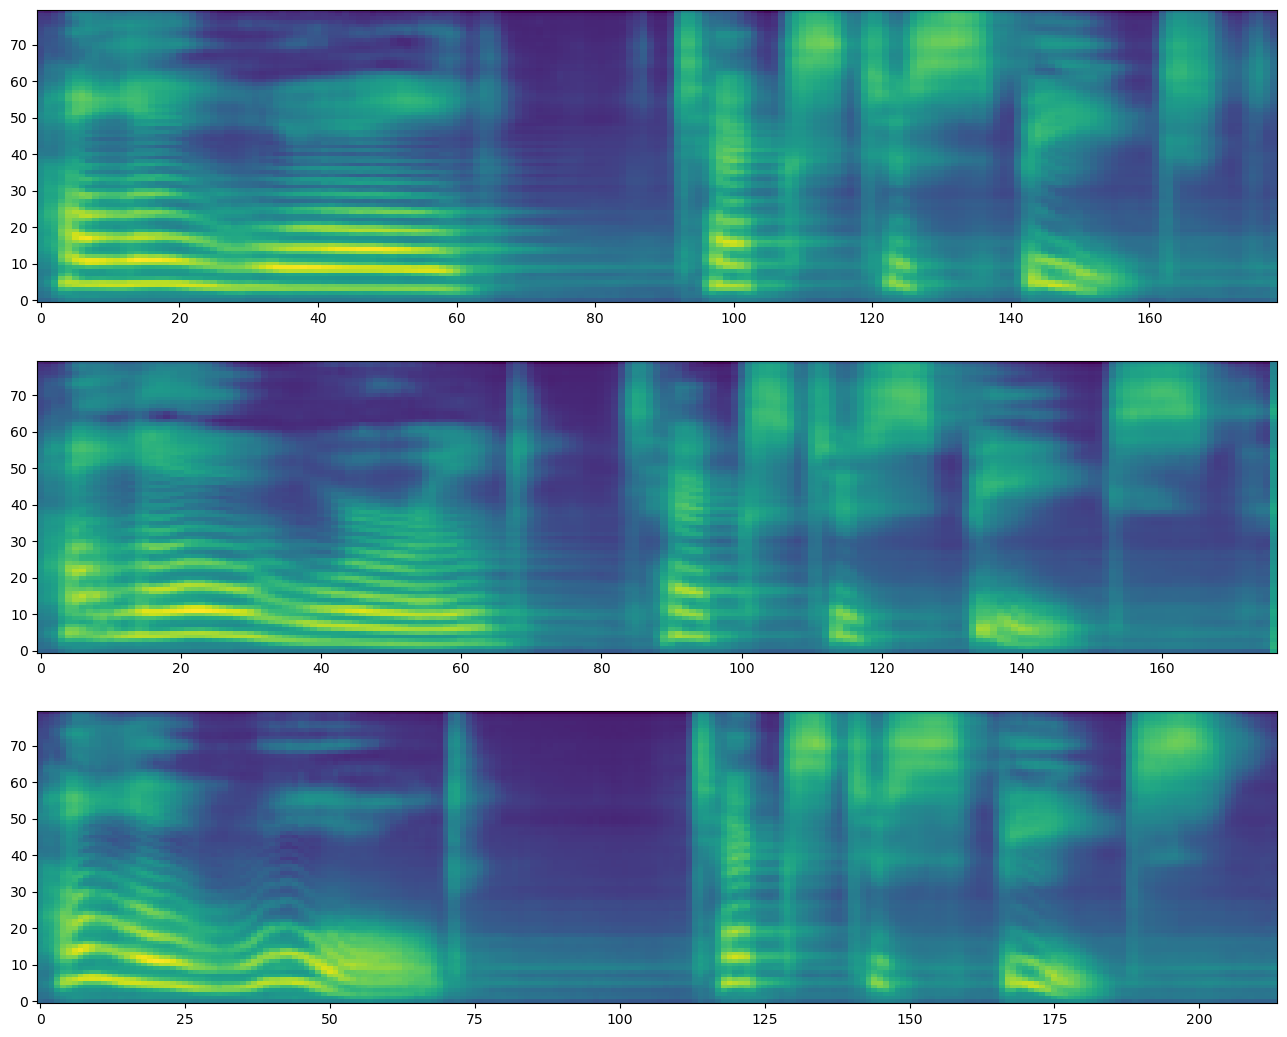

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(16, 4.3 * 3))
for i in range(3):
    with torch.inference_mode():
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    print(spec[0].shape)
    ax[i].imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
plt.show()

In [21]:
# WAVEFORM GENERATION

In [22]:
# WaveRNN

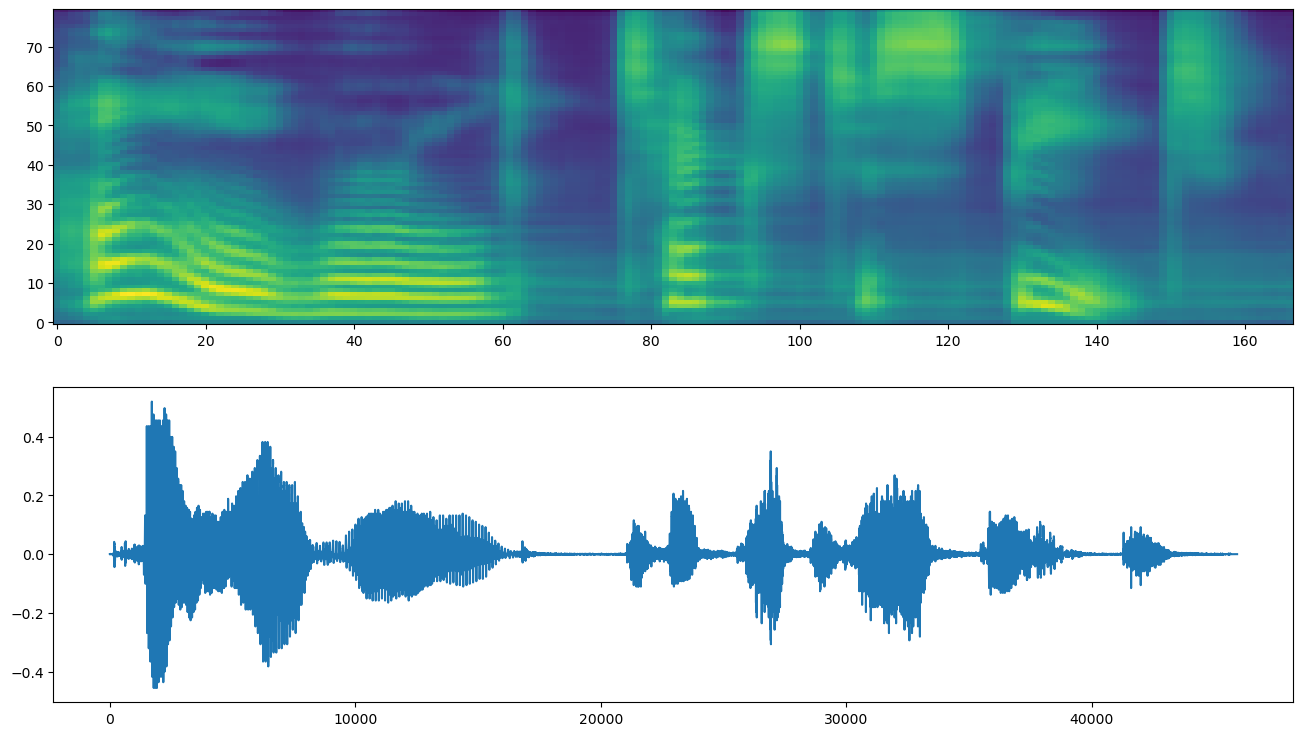

In [4]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lenghts = processor(text)
    processed = processed.to(device)
    lengths = lenghts.to(device)
    spec, spec_lenghts, _ = tacotron2.infer(processed, lenghts)
    waveforms, lengths = vocoder(spec, spec_lenghts)
    
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)

In [5]:
# Griffin-Lim

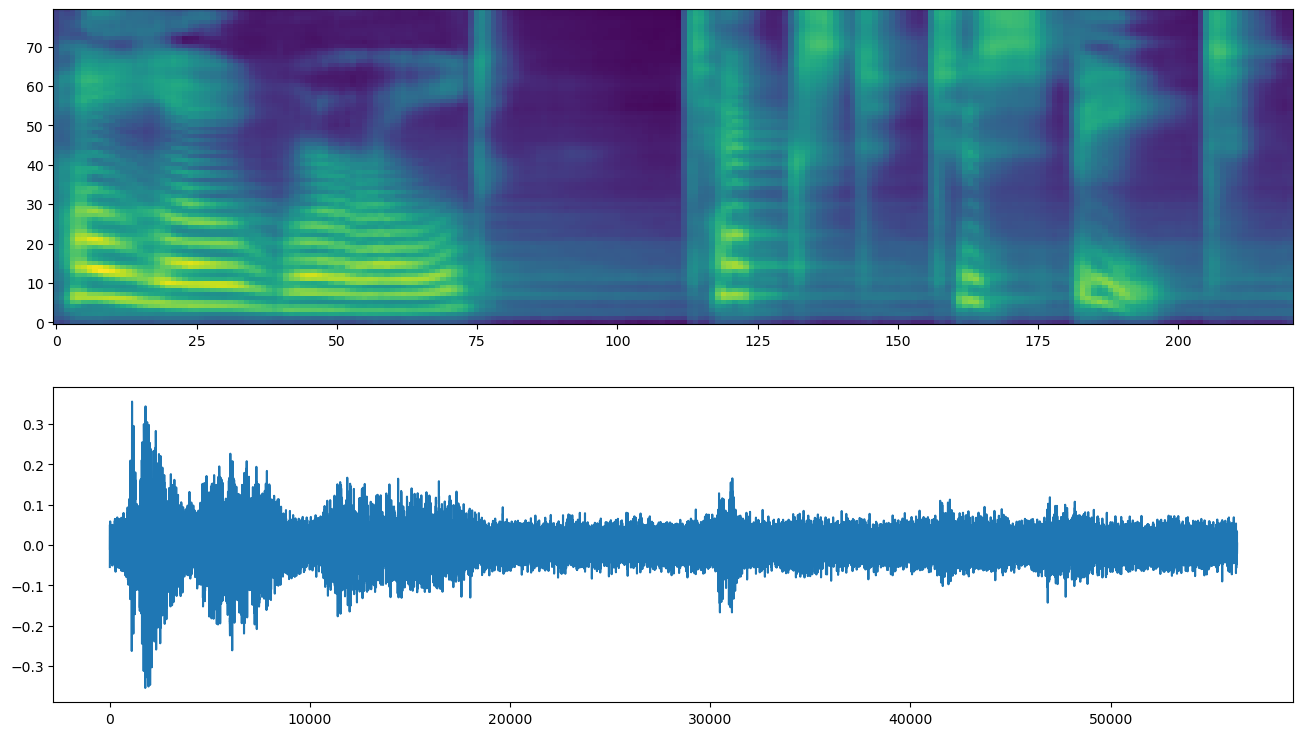

In [5]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
ax2.plot(waveforms[0].cpu().detach())

IPython.display.Audio(waveforms[0:1].cpu(), rate=vocoder.sample_rate)